In [1]:
import os

import mediapipe as mp
from mediapipe.tasks.python import BaseOptions
from mediapipe.tasks.python.vision import GestureRecognizer, GestureRecognizerOptions, GestureRecognizerResult, RunningMode
import cv2 

from IPython.display import display, HTML

from PIL import Image as PILImage

from dm_control import mujoco
from dm_control.rl import control
from dm_control.suite import base

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib

from tqdm import tqdm

from constants import *

In [2]:
class SimTask(base.Task):

    def __init__(self, random=None):
        super(SimTask, self).__init__(random=random)

    def initialize_episode(self, physics):
        with physics.reset_context():
            physics.named.data.qpos[:6] = UR10E_START_POS
            np.copyto(physics.data.ctrl, UR10E_START_POS)
        
        np.copyto(physics.data.mocap_pos[0], physics.named.data.xpos['wrist_3_link'])
        np.copyto(physics.data.mocap_quat[0], physics.named.data.xquat['wrist_3_link'])

        super().initialize_episode(physics)

    def before_step(self, action, physics):
        np.copyto(physics.data.mocap_pos[0], action[0:3])
        np.copyto(physics.data.mocap_quat[0], action[3:7])
    
    def get_observation(self, physics):
        return {
            'images': {
                'top': physics.render(height=240, width=320, camera_id=0),
                'birdview': physics.render(height=240, width=320, camera_id=1),
                'front': physics.render(height=240, width=320, camera_id=2)
            }, 'mocap': {
                'pos': physics.data.mocap_pos[0],
                'quat': physics.data.mocap_quat[0]
            }
        }
    
    def get_reward(self, physics):
        return 0
    
    @staticmethod
    def get_env(control_timestamp_sec=0.02):
        physics = mujoco.Physics.from_xml_path(SCENE_XML_PATH)

        task = SimTask()
        env = control.Environment(
            physics, task, time_limit=10., control_timestep=control_timestamp_sec,
            n_sub_steps=None, flat_observation=None)
        return env
    

In [3]:
class HandTrackingSession:

    def __init__(self, 
                 num_frames=100, 
                 framerate=30,
                 control_scale=0.5,
                 render_robot=False) -> None:
        self.cap = cv2.VideoCapture(0)
        self.cap.set(3, 320) # set width
        self.cap.set(4, 240) # set height

        self.camera_display_handle = None
        self.simnulation_display_handle = None

        self.env = SimTask.get_env(control_timestamp_sec=1.0 / framerate)
        self.num_frames = num_frames
        self.framerate = framerate

        self.control_scale = control_scale

        self.render_robot = render_robot

        self.controls = []
        self.camera_frames = []

        self.simulation_frames = []

        self.init_mocap_pos = None
        self.init_mocap_quat = None


    def callback(self, result: GestureRecognizerResult, output_image: mp.Image, timestamp: int):
        '''
        Async callback function for the gesture recognizer
        '''
        if (len(result.hand_landmarks) > 0):
            landmark = result.hand_landmarks[0][0]
            hand_pos = np.array([landmark.x, landmark.z, landmark.y])
            print(hand_pos, end='\r')
        
            self.controls.append(hand_pos)
        else:
            if (len(self.controls) > 0):
                self.controls.append(self.controls[-1])
            else:
                self.controls.append(np.zeros(3))
        
        camera_frame = output_image.numpy_view()
        self.camera_frames.append(camera_frame)
        
        self.camera_display_handle.update(PILImage.fromarray(camera_frame))

    @staticmethod
    def display_video(frames, framerate=30):
        height, width, _ = frames[0].shape
        dpi = 70
        orig_backend = matplotlib.get_backend()
        matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
        fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
        matplotlib.use(orig_backend)  # Switch back to the original backend.
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_position([0, 0, 1, 1])
        im = ax.imshow(frames[0])
        def update(frame):
            im.set_data(frame)
            return [im]
        interval = 1000/framerate
        anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                        interval=interval, blit=True, repeat=False)
        return HTML(anim.to_html5_video())
    
    def setup_env(self):
        ts = self.env.reset()
        self.init_mocap_pos = ts.observation['mocap']['pos'].copy()
        self.init_mocap_quat = ts.observation['mocap']['quat'].copy()
        self.simulation_frames = [ts.observation['images']['birdview']]
    
    def render_one_frame(self, ctrl_pos):
        ts = self.env.step(np.concatenate([ctrl_pos * self.control_scale + self.init_mocap_pos, 
                                           self.init_mocap_quat]) 
                           )
        return ts.observation['images']['birdview']


    def render(self):
        self.setup_env()

        for i in tqdm(range(self.num_frames)):
            self.simulation_frames.append(self.render_one_frame(self.controls[i]))

        return self.display_video(self.simulation_frames, framerate=self.framerate)
    
    def start(self):
        self.controls = []
        self.camera_frames = []

        self.camera_display_handle = display(None, display_id=True)

        options = GestureRecognizerOptions(
            base_options=BaseOptions(model_asset_path=MODEL_ASSET_PATH),
            running_mode=RunningMode.LIVE_STREAM,
            result_callback=self.callback
            )
        
        timestamp = 0
        with GestureRecognizer.create_from_options(options) as recognizer:
            while self.cap.isOpened():
                ret, frame = self.cap.read()
                if not ret:
                    break
                timestamp += 1
                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
                hand_landmarker_result = recognizer.recognize_async(mp_image, timestamp)

                if cv2.waitKey(1000 // self.framerate) & 0xFF == ord('q'):
                    break

                if timestamp == self.num_frames: # 30 seconds
                    break

    def close(self):
        self.cap.release()
        cv2.destroyAllWindows()

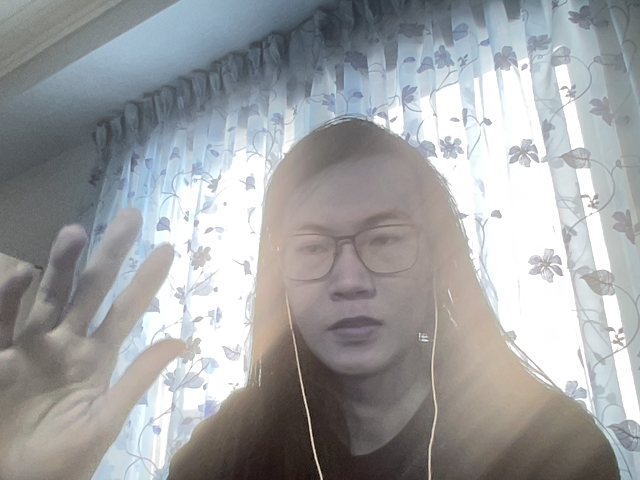

I0000 00:00:1712675614.069710       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1
W0000 00:00:1712675614.070916       1 gesture_recognizer_graph.cc:129] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
I0000 00:00:1712675614.075596       1 hand_gesture_recognizer_graph.cc:250] Custom gesture classifier is not defined.


In [6]:
session = HandTrackingSession(framerate=10, render_robot=False)
session.start()

In [5]:
session.render()

100%|██████████| 100/100 [00:07<00:00, 13.47it/s]
